In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import cv2
import cv2 as cv
import os
import pathlib
import sys
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torchmetrics
from Dataloaders import supervised_loader, test_loader, unsupervised_loader, supervised_train_transform, test_transform, uda_train_transform, geometrical_transform

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)


In [4]:
LEARNING_RATE = 3e-5
BATCH_SIZE = 6
UNSUP_BATCH_SIZE = 16
NUM_EPOCHS = 25
NUM_WORKERS = 2
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 640
PIN_MEMORY = True
LOAD_MODEL = False
LAMBDA = 0.3
TRAIN_IMG_DIR = "segmentation_data/train_imgs"
TRAIN_MASK_DIR = "segmentation_data/train_masks"
VAL_IMG_DIR = "segmentation_data/val_imgs"
VAL_MASK_DIR = "segmentation_data/val_masks"
UNSUPERVISED_DIR = "unlabelled"

In [5]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
lambda1 = lambda epoch: 0.9 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
scaler = torch.cuda.amp.GradScaler()

In [6]:
## loading dataloaders

train_data_loader = supervised_loader(image_dir = TRAIN_IMG_DIR, mask_dir= TRAIN_MASK_DIR,
                                      transform=supervised_train_transform, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,
                                      shape = (IMAGE_WIDTH, IMAGE_HEIGHT))

val_data_loader = supervised_loader(image_dir = VAL_IMG_DIR, mask_dir= VAL_MASK_DIR,
                                      transform=test_transform, batch_size=BATCH_SIZE, shuffle=False, num_workers = 4,
                                      shape = (IMAGE_WIDTH, IMAGE_HEIGHT))
uda_data_loader = unsupervised_loader(image_dir = UNSUPERVISED_DIR,
                                      transform=uda_train_transform, geometrical_transform= geometrical_transform, 
                                      batch_size=UNSUP_BATCH_SIZE, shuffle=True, num_workers = 4,
                                      shape = (IMAGE_WIDTH, IMAGE_HEIGHT))

In [7]:
label_train_iter = iter(train_data_loader)

In [8]:
iou_fn = torchmetrics.classification.JaccardIndex(task = 'binary', threshold = 0., num_classes = 2)

epochs = (range(NUM_EPOCHS))

val_loss = []
train_loss = []

train_iou = []
val_iou = []

max_val_iou = 0
for epoch in epochs:
    
    total_val_loss = 0
    total_train_loss = 0
    total_train_iou = 0
    total_val_iou = 0
    
    ## training part

    for batch_idx, (un_img, un_aug_img) in enumerate(uda_data_loader):
        ## UNSUPERVISED DATA
        un_img = un_img.to(device=DEVICE)
        un_aug_img = un_aug_img.to(device=DEVICE)
        
        
        ## SUPERVISED DATA
        try:
            data ,targets = next(label_train_iter)
        except StopIteration:
            label_train_iter = iter(train_data_loader)
            data, targets = next(label_train_iter)
        
        data = data.to(device = DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            ## unsupervised part for consistency loss
            ref_mask = model(un_img)
            aug_mask = model(un_aug_img)
            
            # ref_mask = torch.sigmoid(ref_mask)
            # aug_mask = torch.sigmoid(aug_mask)
            consistency_loss = loss_fn(aug_mask, ref_mask)
            
            ## supervised part
            predictions = model(data)
            sup_loss = loss_fn(predictions, targets)
        
        ## CALCULATING NET LOSS
        loss = sup_loss + LAMBDA*consistency_loss 

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iou_train = iou_fn(predictions.to("cpu"), ((targets > 0)*1).to("cpu"))
        total_train_iou += iou_train.item()
        # loop.set_postfix(loss=loss.item(), iou_loss = iou_train_loss)
        total_train_loss += loss.item()
        x = optimizer.param_groups[0]["lr"]
        print(f" Epoch - {epoch+1}, Step - {batch_idx+1}/{len(uda_data_loader)}, Lr - {x}, Training_Loss - {round(total_train_loss/(batch_idx+1), 4)}, Train_mIOU - {round(total_train_iou/(batch_idx+1), 4)}", end="\r")
    total_train_loss = total_train_loss/(batch_idx+1)
    total_train_iou = total_train_iou/(batch_idx+1)
    train_loss.append(total_train_loss)
    train_iou.append(total_train_iou)
    scheduler.step()
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_data_loader):
            data = data.to(device=DEVICE)
            targets = targets.float().unsqueeze(1).to(device=DEVICE)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_val_loss += loss.item()
            iou_val = iou_fn(predictions.to("cpu"), ((targets > 0)*1).to("cpu"))
            total_val_iou += iou_val.item()
            # val_loop.set_postfix(val_loss=loss.item(), iou_loss = iou_val_loss)
    total_val_loss = total_val_loss/(batch_idx+1)
    total_val_iou = total_val_iou/(batch_idx+1)
    val_loss.append(total_val_loss)
    val_iou.append(total_val_iou)
    print(f" Epoch - {epoch+1}, Training_Loss - {round(total_train_loss, 4)}, Train_mIOU - {round(total_train_iou, 4)}, Validation_Loss - {round(total_val_loss, 4)}, val_mIOU - {round(total_val_iou, 4)}")

    if total_val_iou>max_val_iou:
        print(f"Validation mIOU increased from {max_val_iou} to {total_val_iou}, Saving Model....")
        torch.save(model.state_dict(), "best_model_uda.ckpt")
        max_val_iou = total_val_iou

 Epoch - 1, Training_Loss - -3.9207, Train_mIOU - 0.7611, Validation_Loss - 0.1134, val_mIOU - 0.9582
Validation mIOU increased from 0 to 0.9581610613009509, Saving Model....
 Epoch - 2, Training_Loss - -10.0918, Train_mIOU - 0.9632, Validation_Loss - 0.0461, val_mIOU - 0.9758
Validation mIOU increased from 0.9581610613009509 to 0.975765198469162, Saving Model....
 Epoch - 3, Training_Loss - -16.9582, Train_mIOU - 0.9747, Validation_Loss - 0.026, val_mIOU - 0.9803
Validation mIOU increased from 0.975765198469162 to 0.9802659539615407, Saving Model....
 Epoch - 4, Training_Loss - -24.8654, Train_mIOU - 0.9774, Validation_Loss - 0.0187, val_mIOU - 0.9817
Validation mIOU increased from 0.9802659539615407 to 0.9817152286277098, Saving Model....
 Epoch - 5, Training_Loss - -33.4034, Train_mIOU - 0.9811, Validation_Loss - 0.0151, val_mIOU - 0.9835
Validation mIOU increased from 0.9817152286277098 to 0.983518057009753, Saving Model....
 Epoch - 6, Training_Loss - -42.1909, Train_mIOU - 0.982,

In [ ]:
plt.plot(train_loss, label="train-loss")
plt.plot(val_loss, label="validation-loss")
plt.legend()
plt.savefig("results/uda_unet_loss.png")

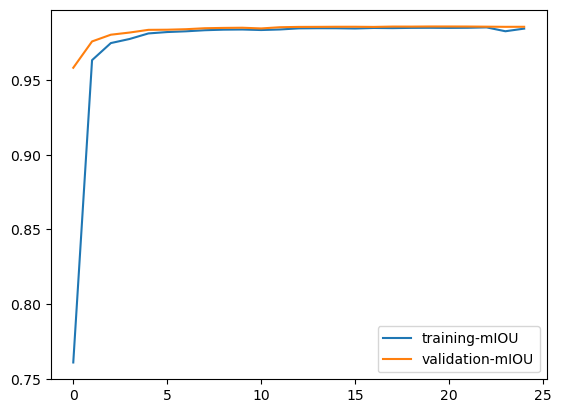

In [10]:
plt.plot(train_iou, label = "training-mIOU")
plt.plot(val_iou, label = "validation-mIOU")
plt.legend()
plt.savefig("results/uda_unet_miou.png")

In [16]:
chkpt = torch.load("weights/unet.ckpt", map_location=DEVICE)
model.load_state_dict(chkpt)
model.eval()
print("Evaluation mode on")

Evaluation mode on


In [63]:
dest = "generated_unets"
cnt = 1
for i in tqdm(os.listdir(UNSUPERVISED_DIR)):
    img_path = UNSUPERVISED_DIR + "/" + i
    orig_img = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (IMAGE_WIDTH, IMAGE_HEIGHT))
    trans_img = test_transform(image = orig_img)["image"]
    trans_img = trans_img.to(DEVICE).unsqueeze(0)
    cv2.imwrite(dest+"/img/" + str(cnt).zfill(4) + ".png", cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(dest+"/unet_mask/" + str(cnt).zfill(4) + ".png", np.uint8(model(trans_img).squeeze().detach().cpu().numpy()>0)*255)
    cnt+=1

100%|██████████| 7000/7000 [13:28<00:00,  8.65it/s]


In [12]:
test_transform = A.Compose([
    A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p = 1.0), 
    ToTensorV2()
])


In [17]:
%%time
img = cv2.imread("test_data/drpremhospital_ccu_mon--E_2023_1_5_7_41_0.jpeg")
img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (IMAGE_WIDTH, IMAGE_HEIGHT))
augmentations = test_transform(image=img)
dat1 = augmentations["image"]

out1 = model(dat1.to(DEVICE).unsqueeze(0))

out1 = out1.squeeze()

CPU times: user 21.3 ms, sys: 5.72 ms, total: 27 ms
Wall time: 21.3 ms


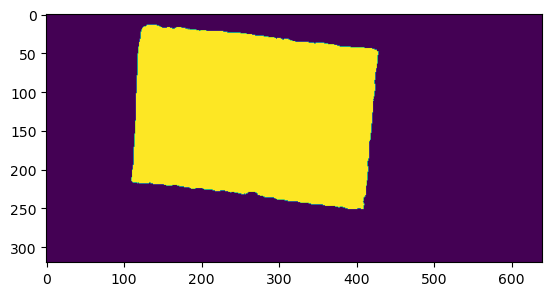

In [18]:
plt.imshow((out1.detach().cpu()>0))

In [19]:
out1

tensor([[-2.3285, -3.1923, -2.9185,  ..., -3.6111, -2.6466, -1.5339],
        [-3.5232, -4.8171, -4.0694,  ..., -6.4019, -4.3417, -3.1318],
        [-4.0815, -5.3266, -4.9444,  ..., -7.3886, -5.1482, -3.3936],
        ...,
        [-3.4995, -4.6030, -3.5862,  ..., -7.3634, -5.4154, -3.6445],
        [-3.1506, -3.9105, -3.5019,  ..., -6.5212, -4.4634, -2.7516],
        [-2.0549, -2.6087, -2.1929,  ..., -4.2615, -3.1520, -1.6643]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)